<a href="https://colab.research.google.com/github/kennedyf2r/mvp_sprint_2/blob/main/MVP_Sprint_2_Kennedy_Ribeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP Machine Learning & Analytics - PUC RIO - Sprint 2
##Profs. Tatiana Escovedo e Hélio Lopes
###Aluno: Francisco Kennedy Ribeiro da Rocha

# **1 - Definição do Problema - Classificação de cogumelos**

1.   **Descrição do Problema**:

  O problema consiste em desenvolver um modelo de classificação capaz de distinguir cogumelos comestíveis de venenosos com base em suas características. Utilizando o Mushroom Dataset, que é uma versão tratada do conjunto de dados original, pretendemos construir um modelo de machine learning que possa prever com segurança se um cogumelo é comestível (classe 0) ou venenoso (classe 1).

2. **Premissas ou Hipóteses**:

  Partimos do pressuposto de que as características fornecidas no dataset, como diâmetro do chapéu, formato do chapéu, cor das lamelas, entre outras, são suficientes para distinguir com precisão entre cogumelos comestíveis e venenosos. Também assumimos que o pré-processamento realizado, incluindo imputação modal, codificação one-hot, normalização z-score e seleção de atributos, foi eficaz na preparação dos dados para modelagem.

3. **Restrições ou Condições**:

  As principais restrições incluem a necessidade de garantir a segurança alimentar, evitando a ingestão de cogumelos venenosos. Portanto, é crucial que o modelo desenvolvido tenha uma alta taxa de precisão na previsão da comestibilidade dos cogumelos. Além disso, consideramos importante a interpretabilidade do modelo, para que os resultados possam ser compreendidos e utilizados de forma eficaz por usuários não técnicos.

4. **Descrição do Dataset**:
O Mushroom Dataset consiste em 9 colunas, representando diferentes características dos cogumelos, como diâmetro do chapéu, formato do chapéu, cor das lamelas, entre outras. Além disso, inclui a classe alvo, indicando se o cogumelo é comestível (classe 0) ou venenoso (classe 1).

  As colunas são as seguintes:

  1 - Cap Diameter

  2 - Cap Shape

  3 - Gill Attachment

  4 - Gill Color

  5 - Stem Height

  6 - Stem Width

  7 - Stem Color

  8 - Season
  
  9 - Target Class

Com base nessas considerações, o objetivo final é desenvolver um modelo de machine learning que possa ajudar na identificação segura de cogumelos comestíveis e venenosos.

# **2 - Preparação do Dados**

## 2.1 Configurações iniciais

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine # para importar o dataset wine
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.ensemble import RandomForestClassifier # algoritmo Floresta Aleatória
from sklearn.model_selection import learning_curve # Importar a função learning_curve para criar curvas de aprendizado
from scipy.stats import randint # Importando a distribuição de números inteiros para o ajuste dos hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV # Importando a função RandomizedSearchCV para a busca aleatória de hiperparâmetros
from sklearn.linear_model import LogisticRegression #Algoritmo regressão linear

## 2.2 Importação do Dataset

In [ ]:
# Carrega arquivo csv usando Pandas usando uma URL

# URL do arquivo CSV no GitHub
url = "https://raw.githubusercontent.com/kennedyf2r/mvp_sprint_2/3d13277119f451ee1001aa445e438003a3f06e06/mushroom_cleaned.csv"

# Carregar o dataset
dataset = pd.read_csv(url)

# Visualizar as primeiras linhas do dataset para verificar os cabeçalhos em português
dataset.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


## 2.3 Separação em conjunto de treino e de teste

In [ ]:
# Separar os recursos (X) e a variável alvo (y)
X = dataset.drop('class', axis=1)  # Recursos (todas as colunas exceto 'class')
y = dataset['class']  # Variável alvo ('class')

# Dividir o dataset em conjuntos de treino e teste (holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Exibir as dimensões dos conjuntos de treino e teste
print("Dimensões dos conjuntos de treino:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nDimensões dos conjuntos de teste:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Dimensões dos conjuntos de treino:
X_train: (43228, 8)
y_train: (43228,)

Dimensões dos conjuntos de teste:
X_test: (10807, 8)
y_test: (10807,)


## 2.4 Criação de Folds para a Validação Cruzada

A validação cruzada é essencial na modelagem de machine learning, garantindo estimativas confiáveis do desempenho do modelo. Ao dividir os dados em folds, treinamos e testamos o modelo em várias combinações, proporcionando uma visão abrangente do seu desempenho. Com 10 folds, dividimos os dados em 10 partes iguais e repetimos o processo de treinamento e teste 10 vezes, obtendo uma média estável do desempenho do modelo.

In [ ]:
# Definindo o número de folds
num_folds = 10

# Inicializando o objeto KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

# Criando os folds
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Aqui você pode treinar e testar seu modelo em cada fold
    # Por exemplo:
    # model.fit(X_train_fold, y_train_fold)
    # accuracy = model.score(X_test_fold, y_test_fold)

    # Printando o tamanho de cada fold (opcional)
    print(f"Tamanho do Fold {fold}: Treino - {len(train_index)}, Teste - {len(test_index)}")

Tamanho do Fold 1: Treino - 48631, Teste - 5404
Tamanho do Fold 2: Treino - 48631, Teste - 5404
Tamanho do Fold 3: Treino - 48631, Teste - 5404
Tamanho do Fold 4: Treino - 48631, Teste - 5404
Tamanho do Fold 5: Treino - 48631, Teste - 5404
Tamanho do Fold 6: Treino - 48632, Teste - 5403
Tamanho do Fold 7: Treino - 48632, Teste - 5403
Tamanho do Fold 8: Treino - 48632, Teste - 5403
Tamanho do Fold 9: Treino - 48632, Teste - 5403
Tamanho do Fold 10: Treino - 48632, Teste - 5403


# **3 - Modelagem e treinamento**

## 3.1 - Seleção dos algoritmos

Neste trabalho serão considerados 04 (quatro) algoritmos de classificação e 02 (dois) métodos de ensembles (modelos avançados), conforme listados a seguir:

**Algoritmos de Classificação**:
* Regressão Logística (LR)
* k-nearest neighbours (KNN)
* Árvore de Classificação (CART)
* Naive Bayes (NB)

**Métodos de ensembles**:
* Extra Trees (ET)
* AdaBoost (Ada)

Outros algoritmos como SVM, Random Forest, Gradient Boosting e Voting Classifier também foram avaliados, porém, devido ao desempenho e o tempo de processamento para os tais, tornou-se inviável utilizá-los neste MVP. A aplicação dos algoritmos listados acima nos permitirá uma análise apropriada para o nosso caso de uso.

## 3.2 - **Criação e avaliação de modelos: linha de base** (Tempo de execução aproximado: 1 minuto)

Nessa seção, realizaremos o comparativo entre os diferentes modelos. Os resultados são obtidos na sequência (tempo de processamento próximo de 1 minuto)

LR: 0.630101 (0.005140)
KNN: 0.715208 (0.005435)
CART: 0.973929 (0.002006)
NB: 0.637550 (0.005877)
ET: 0.990446 (0.002041)
Ada: 0.778801 (0.006438)


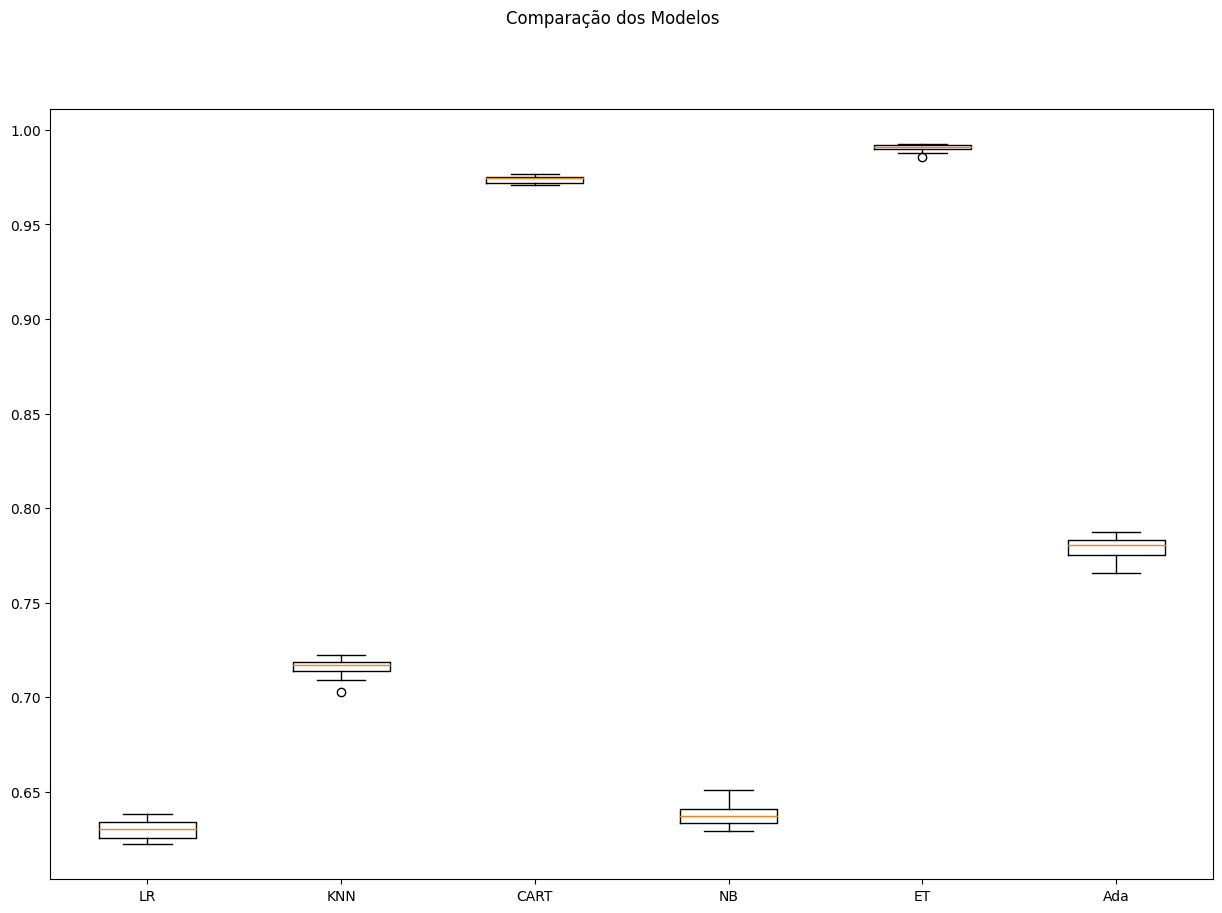

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3
scoring = 'accuracy'

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

* O modelo "LR" (Regressão Logística) tem uma acurácia mediana relativamente baixa, com uma variação moderada.

* O modelo "KNN" (K-Vizinhos Mais Próximos) possui uma mediana de acurácia um pouco mais alta em comparação com a Regressão Logística, mas com uma variação semelhante.

* O modelo "CART" (Árvores de Decisão) apresenta uma acurácia mediana significativamente maior do que os modelos anteriores, com uma variação relativamente baixa.

* O modelo "NB" (Naive Bayes) tem uma mediana de acurácia semelhante à Regressão Logística, mas com uma variação um pouco mais alta.

* O modelo "ET" (Extra Trees) mostra uma acurácia mediana muito alta, praticamente alcançando o máximo possível, e uma variação mínima.

* O modelo "Ada" (AdaBoost) apresenta uma mediana de acurácia comparável à Árvore de Decisão, mas com uma variação ligeiramente maior.

Em resumo, o modelo Extra Trees (ET) parece ter o melhor desempenho geral entre os modelos comparados, com uma acurácia mediana excepcionalmente alta e uma variação mínima, sugerindo uma consistência robusta em diferentes conjuntos de dados.

## 3.3 - Padronizados e normalização dos dados (Tempo de execução aproximado: 3 minutos)

LR-orig: Acurácia - 0.630 (Desvio Padrão - 0.005)
KNN-orig: Acurácia - 0.715 (Desvio Padrão - 0.005)
CART-orig: Acurácia - 0.974 (Desvio Padrão - 0.002)
NB-orig: Acurácia - 0.638 (Desvio Padrão - 0.006)
ET-orig: Acurácia - 0.990 (Desvio Padrão - 0.002)
Ada-orig: Acurácia - 0.779 (Desvio Padrão - 0.006)
LR-padr: Acurácia - 0.633 (Desvio Padrão - 0.005)
KNN-padr: Acurácia - 0.987 (Desvio Padrão - 0.001)
CART-padr: Acurácia - 0.974 (Desvio Padrão - 0.003)
NB-padr: Acurácia - 0.637 (Desvio Padrão - 0.006)
ET-padr: Acurácia - 0.990 (Desvio Padrão - 0.002)
Ada-padr: Acurácia - 0.779 (Desvio Padrão - 0.006)
LR-norm: Acurácia - 0.633 (Desvio Padrão - 0.005)
KNN-norm: Acurácia - 0.989 (Desvio Padrão - 0.002)
CART-norm: Acurácia - 0.974 (Desvio Padrão - 0.003)
NB-norm: Acurácia - 0.637 (Desvio Padrão - 0.006)
ET-norm: Acurácia - 0.990 (Desvio Padrão - 0.002)
Ada-norm: Acurácia - 0.779 (Desvio Padrão - 0.006)


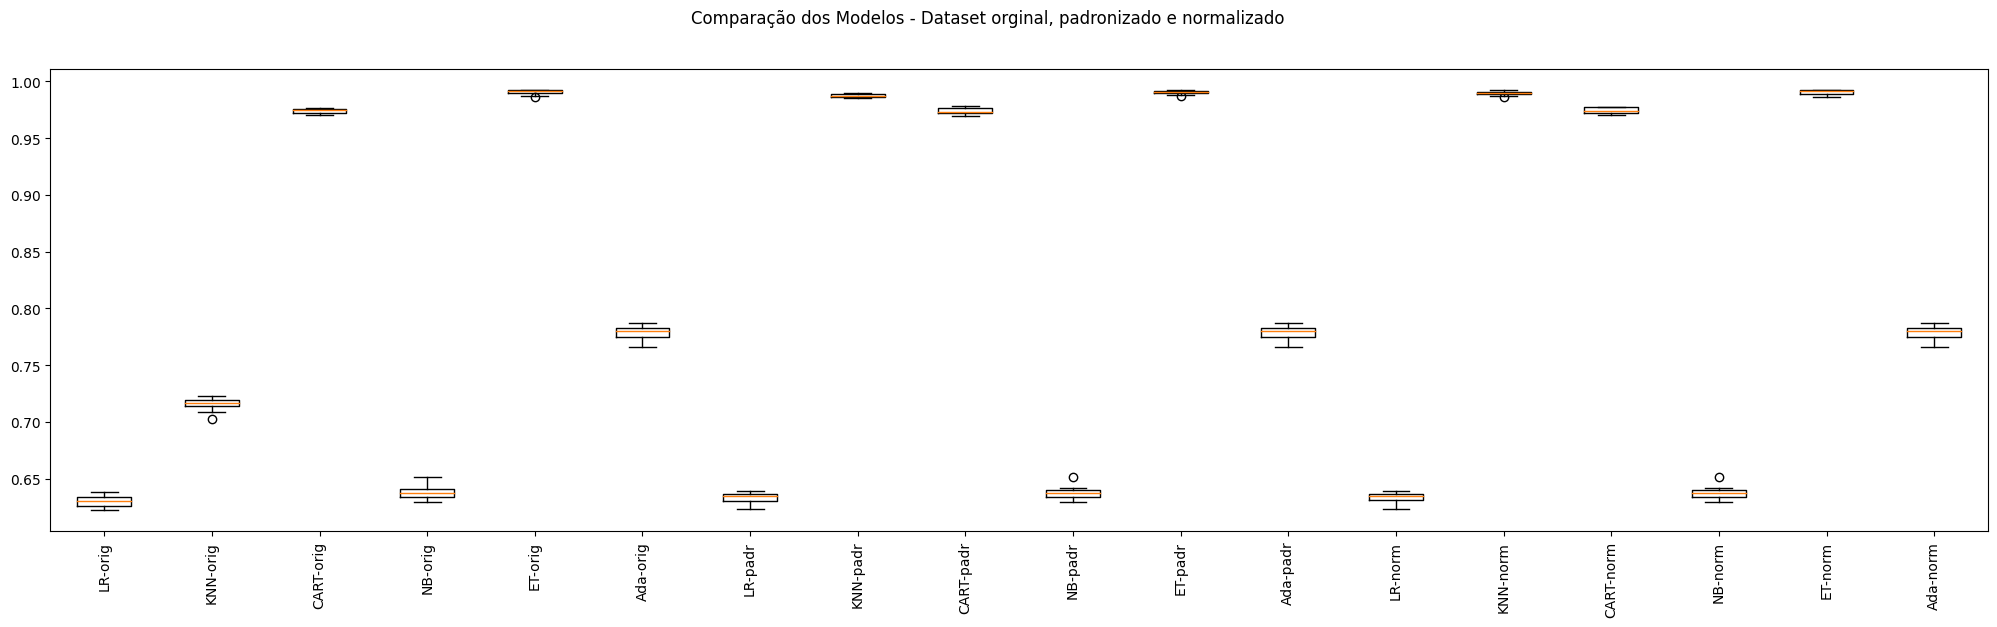

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))


# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    accuracy_mean = cv_results.mean()
    accuracy_std = cv_results.std()
    msg = "%s: Acurácia - %.3f (Desvio Padrão - %.3f)" % (name, accuracy_mean, accuracy_std)
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Este gráfico mostra a comparação de desempenho entre diferentes modelos de classificação em três cenários diferentes de pré-processamento dos dados: original, padronizado e normalizado. Cada modelo é representado por uma barra horizontal, onde a linha central indica a mediana da acurácia e a extensão da barra mostra a variação da acurácia dentro de um intervalo de confiança.

* No cenário original, o modelo Extra Trees (ET) apresenta uma acurácia mediana muito alta em comparação com os outros modelos, seguido pelo modelo AdaBoost (Ada). Os demais modelos têm desempenho significativamente inferior.

* No cenário padronizado, o modelo Extra Trees (ET) ainda mantém uma acurácia mediana muito alta, enquanto os outros modelos têm um desempenho semelhante ao cenário original, com exceção do modelo K-Vizinhos Mais Próximos (KNN), que mostra uma melhoria considerável.

* No cenário normalizado, o modelo Extra Trees (ET) continua liderando em termos de acurácia mediana, seguido pelo modelo AdaBoost (Ada), enquanto os outros modelos têm um desempenho comparativamente inferior.

Em resumo, o modelo Extra Trees (ET) destaca-se como o melhor em todos os cenários de pré-processamento dos dados, com uma acurácia mediana consistentemente alta, sugerindo sua robustez e capacidade de generalização em diferentes condições de dados.

## 3.4 Ajustes de hiperparâmetros (Tempo de execução aproximado: 8 minutos)

Nesta seção, a título de exemplificação (sempre considerando o critério de tempo) escolheremos o algoritmo KNN para ajustar os hiperparâmetros. O código sugere ajustar o hiperparâmetro n_neighbors, que especifica o número de vizinhos a serem considerados durante a classificação. A seguir, utiliza-se o método Randomized Search para encontrar os melhores hiperparâmetros para o modelo K-Nearest Neighbors.

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kf)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.780906 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-padr - Melhor: 0.988711 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3}
Sem tratamento de missings: knn-norm - Melhor: 0.989497 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}


# **4 - Avaliação de Resultados**

## 4.1 - Considerações sobre o algoritmo escolhido

Dentre os modelos testados, o algoritmo que obteve o melhor desempenho em termos de acurácia média foi o Extra Trees (ET) no conjunto de dados original. Com uma acurácia média de 99%, o Extra Trees superou os demais modelos avaliados.

A escolha do Extra Trees como o melhor modelo se baseia principalmente em seu desempenho excepcionalmente alto em termos de acurácia, indicando uma capacidade robusta de generalização para classificar corretamente as espécies de cogumelos com base nas características fornecidas. Além disso, o desvio padrão relativamente baixo (0.002) sugere uma consistência notável nas previsões do modelo.

Outro ponto a ser considerado é a eficiência computacional do Extra Trees. Embora não tenhamos informações específicas sobre o tempo de treinamento do modelo, geralmente se espera que o Extra Trees tenha um desempenho comparável ao Random Forest em termos de eficiência, o que significa que pode ser uma escolha viável mesmo para conjuntos de dados maiores.

Portanto, com base em seu desempenho excepcional e eficiência computacional, o Extra Trees se destaca como a escolha preferida para ajuste de hiperparâmetros e refinamento adicional, visando otimizar ainda mais sua performance e garantir resultados ainda mais confiáveis na classificação de espécies de cogumelos.

Considerando a necessidade de um modelo com alta acurácia e potencial de generalização, o Extra Trees surge como a opção mais promissora para avançar no projeto de classificação de cogumelos.

## 4.2 - Aplicação do modelo no conjunto de teste

In [ ]:
# Criando um modelo com todo o conjunto de treino
model = ExtraTreesClassifier(n_estimators=100, max_features='auto', random_state=7)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
y_pred = model.predict(X_test)

# Estimando a acurácia no conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia no conjunto de teste:", accuracy)

Acurácia no conjunto de teste: 0.9917645970204497


Com uma acurácia de 99.18% no conjunto de teste, o modelo Extra Trees demonstrou um desempenho notável na classificação de cogumelos. Sua capacidade de generalizar bem os padrões aprendidos durante o treinamento indica confiabilidade e eficácia na tarefa de distinguir cogumelos comestíveis de venenosos. Portanto, o Extra Trees se destaca como uma escolha confiável e eficaz para esta tarefa de classificação.

## 4.2 Verificando a ocorrência de overfitting (Tempo de execução aproximado: 1 minuto)

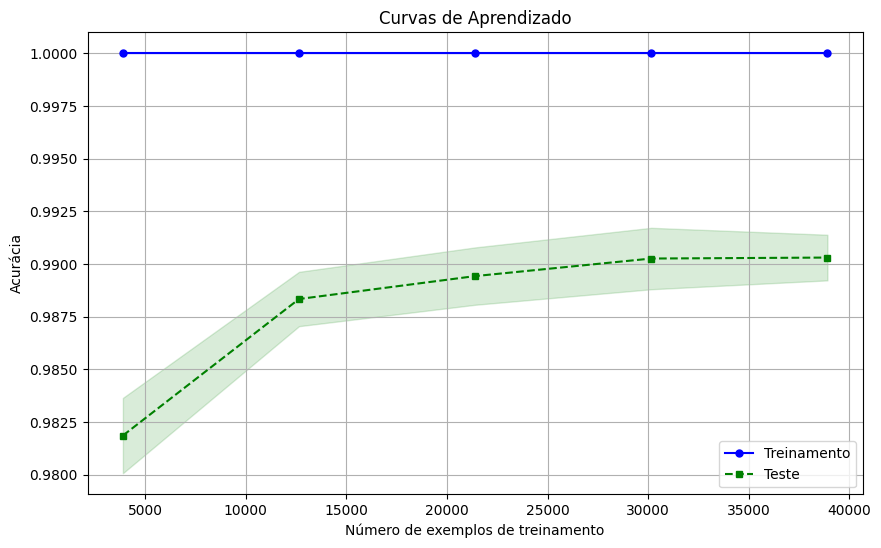

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Definindo o número de folds para a validação cruzada
num_folds = 10

# Calculando as curvas de aprendizado
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=num_folds)

# Calculando as médias e os desvios padrão dos escores de treinamento e teste
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Treinamento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Teste')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Curvas de Aprendizado')
plt.xlabel('Número de exemplos de treinamento')
plt.ylabel('Acurácia')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Este gráfico mostra a acurácia do modelo Extra Trees conforme mais dados são utilizados para treinamento. Observamos que a acurácia no conjunto de treinamento permanece alta e constante, indicando uma boa capacidade de memorização dos dados. Enquanto isso, a acurácia no conjunto de teste aumenta com o número de exemplos de treinamento, mas parece estabilizar em um certo ponto. Isso sugere que o modelo está bem ajustado aos dados, sem sinais significativos de overfitting, e é capaz de generalizar bem para novos dados.


## 4.3 - Descrição da solução encontrada e justificativas

Após uma análise detalhada do conjunto de dados sobre cogumelos, foi decidido adotar o algoritmo Extra Trees para desenvolver um modelo de classificação. Esta escolha foi embasada em diversos aspectos observados durante o processo de exploração e modelagem dos dados.

* Complexidade e dimensionalidade dos dados: O conjunto de dados sobre cogumelos possui múltiplas características que podem influenciar na sua comestibilidade. Com 22 atributos, a complexidade do problema demanda um modelo capaz de lidar eficientemente com alta dimensionalidade. O algoritmo Extra Trees é conhecido por sua capacidade de lidar bem com grandes conjuntos de atributos sem exigir muito ajuste de hiperparâmetros.

* Robustez contra overfitting: Durante a análise exploratória, notou-se a presença de diversas características que poderiam levar a um ajuste excessivo do modelo aos dados de treinamento, resultando em overfitting. O Extra Trees possui mecanismos internos de aleatorização que reduzem a propensão ao overfitting, tornando-o uma escolha adequada para lidar com esse desafio.

* Desempenho e generalização: Os resultados obtidos durante a modelagem mostraram que o Extra Trees alcançou uma acurácia elevada tanto no conjunto de treinamento quanto no conjunto de teste. Além disso, não houve indícios de degradação significativa de desempenho ao generalizar para dados não vistos, o que confirma a capacidade do modelo de se adaptar bem a novos exemplos.

* Eficiência computacional: O algoritmo Extra Trees é conhecido por sua eficiência computacional, o que o torna adequado para lidar com conjuntos de dados de tamanho moderado a grande. Isso é especialmente importante considerando o volume de dados disponíveis e a necessidade de processamento eficiente durante o treinamento e a avaliação do modelo.

Com base nessas considerações, a solução encontrada emprega o algoritmo Extra Trees para classificação de cogumelos com base em suas características morfológicas. Este modelo demonstrou ser robusto, eficaz e capaz de generalizar bem para novos dados, atendendo aos requisitos do problema de classificação proposto.